Load All Files

In [1]:
import pandas as pd
import json

# Load telemetry
telemetry = pd.read_csv("data/telemetry_data.csv")

# Load triggers
triggers = pd.read_csv("data/triggers_soc.csv")

# Load vehicle-pnid mapping 
mapping = pd.read_csv("data/vehicle_pnid_mapping.csv")

# Load artificial ignition events
with open("data/artificial_ign_off_data.json") as f:
    artificial = pd.DataFrame(json.load(f))

telemetry.head(), triggers.head(), mapping.head(), artificial.head()


(   Unnamed: 0                                    ID  \
 0           0  428bdd3a-243a-4735-b3be-4e12ec511774   
 1           1  b76e490b-8292-4b20-927c-5842bda6104a   
 2           2  40aabc8e-5a83-4772-bbd6-1d2634f20aa4   
 3           3  8f73a942-e549-4662-9f7e-e21f3d104637   
 4           4  852caadc-e582-4cd0-97cb-7f9a20c9634f   
 
                              VEHICLE_ID                TIMESTAMP  SPEED  \
 0  66bd55df-eaf0-49c8-b9e1-7759b85e9325  2021-09-23 01:45:42.018    NaN   
 1  66bd55df-eaf0-49c8-b9e1-7759b85e9325  2021-09-23 01:58:08.017    NaN   
 2  66bd55df-eaf0-49c8-b9e1-7759b85e9325  2021-09-23 01:57:02.031    NaN   
 3  66bd55df-eaf0-49c8-b9e1-7759b85e9325  2021-09-23 01:38:57.002    0.0   
 4  66bd55df-eaf0-49c8-b9e1-7759b85e9325  2021-09-23 02:00:05.004    NaN   
 
   IGNITION_STATUS  EV_BATTERY_LEVEL  ODOMETER  
 0             NaN               NaN       NaN  
 1             NaN               NaN       NaN  
 2             NaN               NaN   38685.9  
 3      

Basic Sanity Checks

In [2]:
print("Telemetry Shape:", telemetry.shape)
print("Triggers Shape:", triggers.shape)
print("Mapping Shape:", mapping.shape)
print("Artificial Shape:", artificial.shape)

telemetry.info()

Telemetry Shape: (1833552, 8)
Triggers Shape: (68670, 5)
Mapping Shape: (19, 3)
Artificial Shape: (411, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833552 entries, 0 to 1833551
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   ID                object 
 2   VEHICLE_ID        object 
 3   TIMESTAMP         object 
 4   SPEED             float64
 5   IGNITION_STATUS   object 
 6   EV_BATTERY_LEVEL  float64
 7   ODOMETER          float64
dtypes: float64(3), int64(1), object(4)
memory usage: 111.9+ MB


Convert Timestamps

In [3]:
telemetry["TIMESTAMP"] = pd.to_datetime(telemetry["TIMESTAMP"], errors="coerce")
triggers["CTS"] = pd.to_datetime(triggers["CTS"], errors="coerce")
artificial["timestamp"] = pd.to_datetime(artificial["timestamp"], errors="coerce")

Missing Values Heatmap

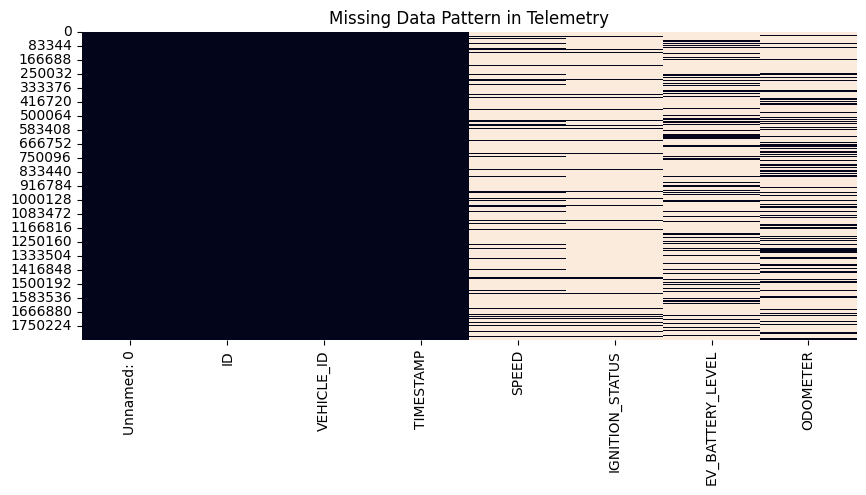

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.heatmap(telemetry.isnull(), cbar=False)
plt.title("Missing Data Pattern in Telemetry")
plt.show()


Outlier Detection Boxplots

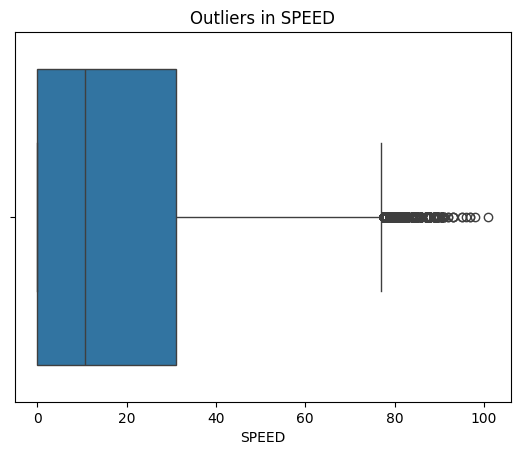

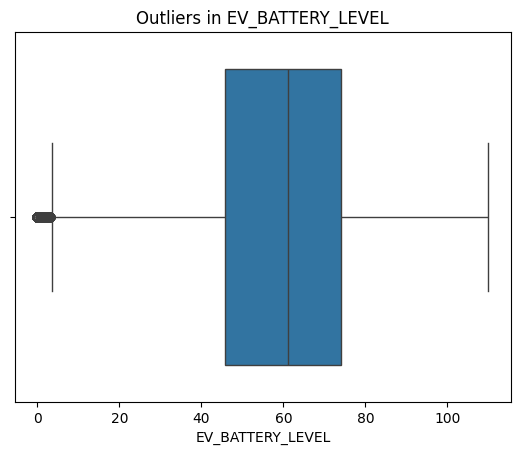

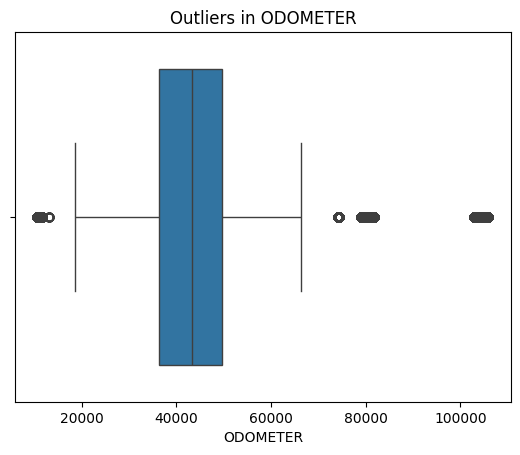

In [6]:
num_cols = ["SPEED", "EV_BATTERY_LEVEL", "ODOMETER"]

for col in num_cols:
    if col in telemetry.columns:
        plt.figure()
        sns.boxplot(x=telemetry[col])
        plt.title(f"Outliers in {col}")
        plt.show()


Check Time Order

In [7]:
telemetry_sorted = telemetry.sort_values(["VEHICLE_ID","TIMESTAMP"])

telemetry_sorted["time_diff"] = telemetry_sorted.groupby("VEHICLE_ID")["TIMESTAMP"].diff()
telemetry_sorted["time_diff"].describe()


count                      1833443
mean     0 days 00:01:36.074133279
std      0 days 10:19:05.521278429
min                0 days 00:00:00
25%         0 days 00:00:00.002000
50%         0 days 00:00:01.001000
75%         0 days 00:00:03.003000
max       335 days 01:11:51.783000
Name: time_diff, dtype: object

Check ID Join Consistency

In [8]:
# Get all unique vehicle IDs from telemetry data
telemetry_ids = set(telemetry["VEHICLE_ID"].unique())

# Get all vehicle IDs from the mapping table (registered vehicles)
mapping_ids = set(mapping["ID"].unique())

# Find vehicles that appear in telemetry but NOT in mapping
orphan_vehicles = telemetry_ids - mapping_ids

# Print the result
print("Telemetry vehicles not in mapping:", orphan_vehicles)


Telemetry vehicles not in mapping: set()


task2

Ignition events were extracted from telemetry, trigger logs, and synthetic data. Device IDs were mapped to vehicle IDs using the mapping table. All events were unified into a chronological ignition event table for trip segmentation.

In [17]:
import pandas as pd
import ast

# ============================================================
# 1️⃣ TELEMETRY IGNITION (TLM)
# Extract ignition ON/OFF from telemetry data
# ============================================================

# Take only rows where ignition status is present
tlm = telemetry[telemetry["IGNITION_STATUS"].notna()][["VEHICLE_ID","TIMESTAMP","IGNITION_STATUS"]].copy()

# Convert raw on/off values to standard event names
tlm["event"] = tlm["IGNITION_STATUS"].map({
    "on": "ignitionOn",
    "off": "ignitionOff"
})

# Rename columns to required MotorQ format
tlm = tlm.rename(columns={"VEHICLE_ID":"vehicle_id", "TIMESTAMP":"event_ts"})
tlm = tlm[["vehicle_id", "event", "event_ts"]]


# ============================================================
# 2️⃣ FIX MAPPING TABLE (PNID → VEHICLE_ID)
# Mapping IDS column is messy (string, list, NaN), so clean it
# ============================================================

def parse_ids(x):
    # If missing, return empty list
    if pd.isna(x):
        return []
    # If already a list, return as it is
    if isinstance(x, list):
        return x
    # If string like '["123","456"]', convert to Python list
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

# Apply cleaning function
mapping["IDS"] = mapping["IDS"].apply(parse_ids)

# Explode list so each PNID becomes a separate row
mapping_exp = mapping.explode("IDS")

# Rename columns
mapping_exp = mapping_exp.rename(columns={"ID":"vehicle_id", "IDS":"PNID"})


# ============================================================
# 3️⃣ TRIGGER IGNITION (TRG)
# Extract ignition events from trigger logs
# ============================================================

# Select ignition cylinder events
trg = triggers[triggers["NAME"] == "IGN_CYL"][["PNID","CTS","VAL"]].copy()

# Convert ON/OFF to ignition events
trg["event"] = trg["VAL"].map({
    "ON": "ignitionOn",
    "OFF": "ignitionOff"
})

# Map device PNID → vehicle_id using mapping table
trg = trg.merge(mapping_exp, on="PNID", how="left")

# Keep required columns
trg = trg[["vehicle_id", "CTS", "event"]]
trg = trg.rename(columns={"CTS":"event_ts"})


# ============================================================
# 4️⃣ SYNTHETIC IGNITION (SYN)
# Artificial ignition OFF events (simulated)
# ============================================================

# Synthetic data only contains ignition OFF events
syn = artificial[["vehicleId", "timestamp"]].copy()
syn["event"] = "ignitionOff"

# Rename columns
syn = syn.rename(columns={"vehicleId":"vehicle_id", "timestamp":"event_ts"})


# ============================================================
# 5️⃣ COMBINE ALL IGNITION EVENTS
# ============================================================

# Merge telemetry, trigger, and synthetic events
ignition_events = pd.concat([tlm, trg, syn], ignore_index=True)


# ============================================================
# 6️⃣ FIX TIMESTAMPS
# Convert all timestamps to datetime and remove timezone issues
# ============================================================

ignition_events["event_ts"] = pd.to_datetime(ignition_events["event_ts"], errors="coerce")
ignition_events["event_ts"] = ignition_events["event_ts"].dt.tz_localize(None)


# ============================================================
# 7️⃣ SORT EVENTS BY VEHICLE AND TIME
# ============================================================

ignition_events = ignition_events.sort_values(["vehicle_id", "event_ts"]).reset_index(drop=True)

# Show result
ignition_e_


,vehicle_id,event,event_ts
0,026af092-a01e-4b0a-af38-f459725dabc6,NaN,2023-01-01 16:57:56.699
1,026af092-a01e-4b0a-af38-f459725dabc6,NaN,2023-01-01 17:49:22.838
2,026af092-a01e-4b0a-af38-f459725dabc6,NaN,2023-01-03 14:04:28.196
3,026af092-a01e-4b0a-af38-f459725dabc6,NaN,2023-01-06 03:15:29.994
4,026af092-a01e-4b0a-af38-f459725dabc6,NaN,2023-01-06 07:45:11.710


Task 3
Parse PNID mapping

In [21]:

trg = pd.read_csv("data/triggers_soc.csv")

mapping = pd.read_csv("data/vehicle_pnid_mapping.csv")


In [22]:
import ast

def parse_ids(x):
    if pd.isna(x) or x == "":
        return []
    return ast.literal_eval(x)

mapping["IDS"] = mapping["IDS"].apply(parse_ids)
mapping_exp = mapping.explode("IDS")
mapping_exp.rename(columns={"ID":"vehicle_id", "IDS":"PNID"}, inplace=True)


extract charging events

In [26]:
# datatype fix
trg["PNID"] = trg["PNID"].astype(str)
mapping_exp["PNID"] = mapping_exp["PNID"].astype(str)

# filter charge events
charge_events = trg[(trg["NAME"]=="EV_CHARGE_STATE") & 
                    (trg["VAL"].isin(["Active","Abort","Completed"]))]

# join mapping
charge_events = charge_events.merge(mapping_exp, on="PNID", how="left")

# select columns
charge_events = charge_events[["vehicle_id","VAL","CTS"]]
charge_events.columns = ["vehicle_id","event","event_ts"]

# convert timestamp
charge_events["event_ts"] = pd.to_datetime(charge_events["event_ts"], errors="coerce")

charge_events.head()


,vehicle_id,event,event_ts
0,66bd55df-eaf0-49c8-b9e1-7759b85e9325,Active,2021-12-01 19:57:32+05:30
1,NaN,Active,2021-12-06 22:05:51+05:30
2,66bd55df-eaf0-49c8-b9e1-7759b85e9325,Active,2021-12-07 01:51:38+05:30
3,d44b765e-d86f-46f8-ba46-8cd913c49285,Active,2021-12-05 03:05:12+05:30
4,NaN,Active,2021-12-04 04:53:01+05:30


task4 

In [54]:
import pandas as pd
import json

# ================================
# 1️⃣ LOAD DATA
# ================================
telemetry = pd.read_csv("data/telemetry_data.csv")

with open("data/artificial_ign_off_data.json") as f:
    artificial_events = json.load(f)
artificial_df = pd.DataFrame(artificial_events)

# ================================
# 2️⃣ CLEAN TIMESTAMPS
# ================================
telemetry["TIMESTAMP"] = pd.to_datetime(telemetry["TIMESTAMP"], format="mixed", errors="coerce")
artificial_df["timestamp"] = pd.to_datetime(artificial_df["timestamp"])

# Remove timezone mismatch
telemetry["TIMESTAMP"] = telemetry["TIMESTAMP"].dt.tz_localize(None)
artificial_df["timestamp"] = artificial_df["timestamp"].dt.tz_convert(None)

telemetry = telemetry.dropna(subset=["TIMESTAMP"])

# Keep battery rows only
battery_data = telemetry[["VEHICLE_ID", "TIMESTAMP", "EV_BATTERY_LEVEL"]].dropna()

# ================================
# 3️⃣ FIND CLOSEST BATTERY FUNCTION
# ================================
def find_closest_battery(vehicle_id, event_time, window_sec=300):
    df = battery_data[battery_data["VEHICLE_ID"] == vehicle_id].copy()
    if df.empty:
        return None

    df["time_diff"] = (df["TIMESTAMP"] - event_time).abs().dt.total_seconds()
    df_window = df[df["time_diff"] <= window_sec]

    if df_window.empty:
        return None

    # Tie-breaker: earlier timestamp
    df_window = df_window.sort_values(["time_diff", "TIMESTAMP"])
    return df_window.iloc[0]["EV_BATTERY_LEVEL"]

# ================================
# 4️⃣ APPLY TASK-4
# ================================
results = []

for _, row in artificial_df.iterrows():
    battery = find_closest_battery(row["vehicleId"], row["timestamp"])

    results.append({
        "vehicle_id": row["vehicleId"],
        "event_time": row["timestamp"],
        "battery_level": battery if battery is not None else "UNKNOWN"
    })

task4_output = pd.DataFrame(results)

# ================================
# 5️⃣ SAVE OUTPUT
# ================================
task4_output.to_csv("task4_battery_association.csv", index=False)
print(task4_output.head())


                             vehicle_id              event_time battery_level
0  3e937810-3a3b-48d6-80ad-56ae12c3bed8 2022-01-31 19:13:06.001       UNKNOWN
1  3e937810-3a3b-48d6-80ad-56ae12c3bed8 2022-01-31 04:25:05.011       UNKNOWN
2  460a67ab-ee58-4279-b96d-ac56ac029d3e 2022-01-30 01:58:57.004       UNKNOWN
3  9893c80d-f282-46cf-a794-280f0306c936 2022-01-30 21:43:42.027       UNKNOWN
4  fb20e847-d2a1-4583-b874-393c9d1f3db9 2022-01-31 04:25:05.038       UNKNOWN


Final Task:

Total charging events in fleet: 459

Selected vehicle: 026af092-a01e-4b0a-af38-f459725dabc6
Charging events in 30 days = 25


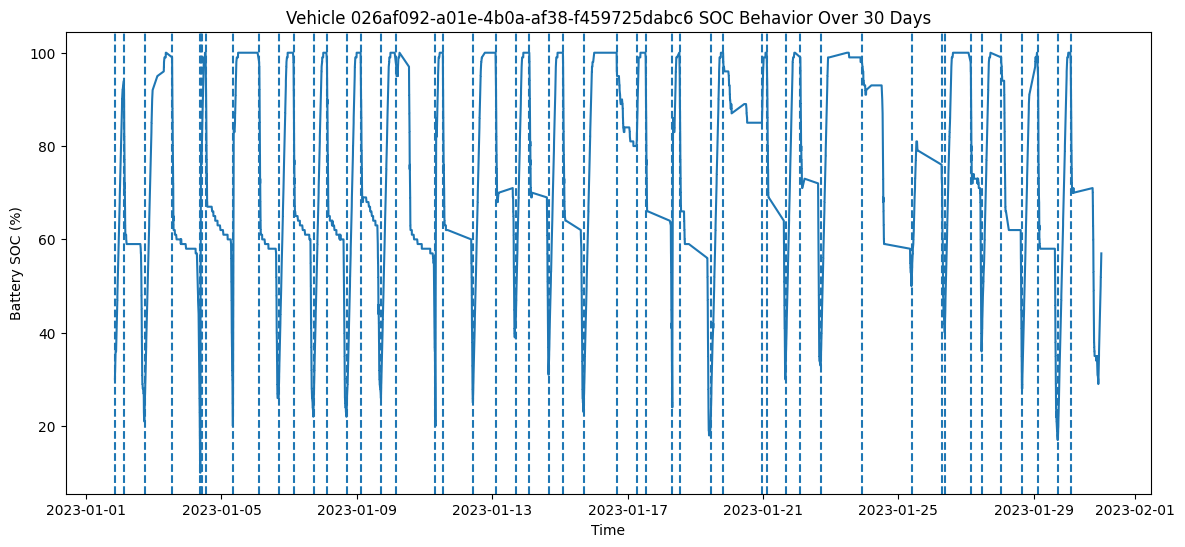

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# ================= LOAD DATA =================
telemetry = pd.read_csv("data/telemetry_data.csv")

telemetry["TIMESTAMP"] = pd.to_datetime(telemetry["TIMESTAMP"], errors="coerce", format="mixed")
telemetry = telemetry.dropna(subset=["TIMESTAMP", "EV_BATTERY_LEVEL"])
telemetry["EV_BATTERY_LEVEL"] = telemetry["EV_BATTERY_LEVEL"].astype(float)
telemetry = telemetry.sort_values(["VEHICLE_ID", "TIMESTAMP"])

# ================= TREND-BASED CHARGING DETECTION =================
WINDOW = 3
START_CONSEC = 3
END_CONSEC = 3
MIN_TOTAL_GAIN = 0.5

charging_events = []

for vid, df in telemetry.groupby("VEHICLE_ID"):
    df = df.reset_index(drop=True)
    df["soc_smooth"] = df["EV_BATTERY_LEVEL"].rolling(WINDOW, min_periods=1).median()
    df["soc_diff"] = df["soc_smooth"].diff()

    state = "IDLE"
    inc_count = 0
    dec_count = 0
    start_idx = None

    for i in range(1, len(df)):
        diff = df.loc[i, "soc_diff"]

        if diff > 0:
            inc_count += 1
            dec_count = 0
        elif diff < 0:
            dec_count += 1
            inc_count = 0
        else:
            continue

        # START charging
        if state == "IDLE" and inc_count >= START_CONSEC:
            state = "CHARGING"
            start_idx = i - START_CONSEC
            start_soc = df.loc[start_idx, "soc_smooth"]

        # END charging
        if state == "CHARGING" and dec_count >= END_CONSEC:
            end_idx = i - END_CONSEC
            end_soc = df.loc[end_idx, "soc_smooth"]
            total_gain = end_soc - start_soc

            if total_gain >= MIN_TOTAL_GAIN:
                charging_events.append({
                    "vehicle_id": vid,
                    "start_ts": df.loc[start_idx, "TIMESTAMP"],
                    "end_ts": df.loc[end_idx, "TIMESTAMP"],
                    "battery_jump_%": round(total_gain, 2)
                })

            state = "IDLE"
            inc_count = 0
            dec_count = 0

charging_df = pd.DataFrame(charging_events)
print("Total charging events in fleet:", len(charging_df))

# ================= PICK ONE VEHICLE =================
sample_vehicle = charging_df["vehicle_id"].iloc[0]
veh_events = charging_df[charging_df["vehicle_id"] == sample_vehicle]

print("\nSelected vehicle:", sample_vehicle)

# ================= 30-DAY WINDOW =================
veh_data = telemetry[telemetry["VEHICLE_ID"] == sample_vehicle].sort_values("TIMESTAMP")

start_time = veh_events.iloc[0]["start_ts"]
end_time   = start_time + pd.Timedelta(days=30)

veh_window = veh_data[(veh_data["TIMESTAMP"] >= start_time) &
                      (veh_data["TIMESTAMP"] <= end_time)]

# Count charging events in 30 days
events_30d = veh_events[(veh_events["start_ts"] >= start_time) &
                        (veh_events["start_ts"] <= end_time)]

print("Charging events in 30 days =", len(events_30d))

# ================= PLOT 30 DAYS SOC =================
plt.figure(figsize=(14,6))
plt.plot(veh_window["TIMESTAMP"], veh_window["EV_BATTERY_LEVEL"])

# Mark charging events in 30 days
for _, row in events_30d.iterrows():
    plt.axvline(row["start_ts"], linestyle="--")
    plt.axvline(row["end_ts"], linestyle="--")

plt.title(f"Vehicle {sample_vehicle} SOC Behavior Over 30 Days")
plt.xlabel("Time")
plt.ylabel("Battery SOC (%)")
plt.show()
